In [8]:
#matplotlib widget
import numpy as np
import pandas as pd
import struct
import bisect
import time
import os
import datetime as datetime
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, leastsq
from scipy.signal import find_peaks, find_peaks_cwt
plt.rcParams["figure.autolayout"] = True; plt.rc('font', size=12); plt.rcParams["figure.max_open_warning"] = False
plt.rc('text', usetex=False); plt.rc('font', family='serif'); plt.rcParams["figure.figsize"] = (8,4)

def steinhartHartFun10k(res):
        return 1 / (588.657649 + -35.6279664*np.log(res) + 0.0487316544*(np.log(res))**3)

def steinhartHartFun100k(res):
        return 1 / (517.183511 + -35.2072073*np.log(res) + 0.0749966054*(np.log(res))**3)



In [14]:
phase_filename='/phase_L6+25m_SM_fiber_EPM400_d0824_1107am_8000Hz.bin' ;#just copy the file name, should be format phase_LXX_dxxxx_XXam_xxam
temp_filename='/omega_d0824_0353pm.xlsx' ; #just copy the file name, should be format tempinvolt_dxxxx_XXam_xxam

phase_path='/Volumes/Shared/AdvancedInterconnects/Qingjun/phase measurement quadrature/phase logger data'
temp_path='/Volumes/Shared/AdvancedInterconnects/Qingjun/phase measurement quadrature/omega temp'

#phase_path='Z:\AdvancedInterconnects\Qingjun\phase measurement quadrature\phase logger data'
#temp_path='Z:\AdvancedInterconnects\Qingjun\phase measurement quadrature\omega temp'

fileNamePhase = phase_path + phase_filename
fileNameTemp = temp_path+ temp_filename

#some information about the bin file decode
Bit: The smallest unit of digital data, representing either a 0 or a 1.
Byte: A group of 8 bits, used to represent a wider range of data, including characters, numbers, etc.
Double (64-bit floating-point number)

char=d ,unixtimestamp=1692916852 ,columnNum=4, datasize/#row=88286


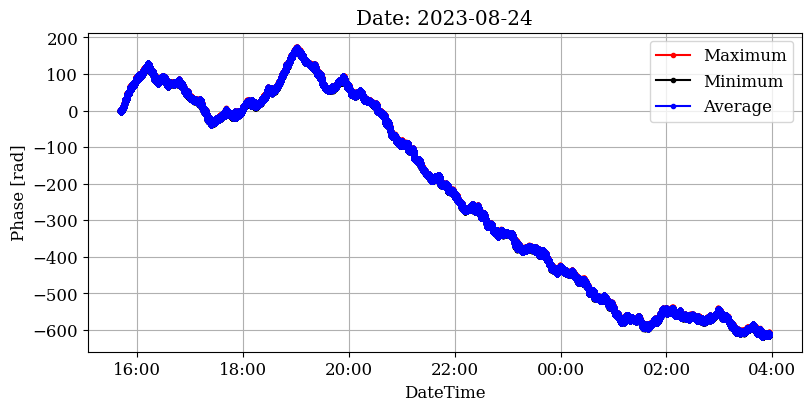

In [21]:
## phase read bin and phase plot
if not os.path.isfile(fileNamePhase + '.csv'): 
    fileStats = os.stat(fileNamePhase); fileHandler = open(fileNamePhase, 'rb') #"rb": binary read mode
    ## start parsing
    charHandler = fileHandler.read(1).decode('utf-8') ## 1 byte for char
    if charHandler == 'c':
        columnNum = int.from_bytes(fileHandler.read(4), 'little') ## 4 bytes for int32 (32-it integer)
        dataSize = round((fileStats.st_size-1-4)/(columnNum*8)) #how many rows  # (fileSize - 1 (char) - 4 (int32))/(columnNum*8 (double))  fileStats.st_size: the size of the file in bytes 
        datetimeInit = datetime.datetime.fromtimestamp(os.path.getctime(fileNamePhase))  
        #datetimeInit = datetime.datetime.fromtimestamp(fileStats.st_ctime) ## datetime from file created stats
        print(f"char={charHandler},columnNum={columnNum}, datasize/#row={dataSize}")
    elif charHandler == 'd':
        unixTimeStamp = int.from_bytes(fileHandler.read(8), 'little') ## 8 bytes for datetime
        columnNum = int.from_bytes(fileHandler.read(4), 'little') ## 4 bytes for int32
        dataSize = round((fileStats.st_size-1-8-4)/(columnNum*8)) ## (fileSize - 1 (char) - 8 (datetime) - 4 (int32))/(columnNum*8 (double))
        datetimeInit = datetime.datetime.fromtimestamp(unixTimeStamp) ## datetime from unixtimestamp [UTC conversion is not working, need to check with Massimo]
        #datetimeInit = datetime.datetime.fromtimestamp(os.path.getctime(fileNamePhase))  
        #datetimeInit = datetime.datetime.fromtimestamp(fileStats.st_ctime) ## datetime from file created stats
        print(f"char={charHandler} ,unixtimestamp={unixTimeStamp} ,columnNum={columnNum}, datasize/#row={dataSize}")

    ## prepare the dataFramePhase, initialize with columnNum
    dataFramePhase = pd.DataFrame()
    columnNames = [f'data{i}' for i in range(columnNum)] ## making list of header names 'data0', 'data1', 'data2', etc...
    for i in columnNames: ## assigning header to the dataframe AND set each column to an empty list
        dataFramePhase[i] = []

    ## data parsing
    #temporary = fileHandler.read(8);
    
    j = 0 ## read the first data, the first eight bytes
    while j <= dataSize-1: ## until dataSize, loop
        #if j=1
#         now1=datetime.datetime.now()
        temporary1 = [] ## array to pack the doubles
        for i in columnNames: ## loop for columnNum
            temporary = fileHandler.read(8) ## read
            temporary_tran=struct.unpack('d', temporary)[0] ## unpack to double
            temporary1.append(temporary_tran) 
#             temporary = fileHandler.read(8) ## read again
        dataFramePhase.loc[len(dataFramePhase)] = temporary1 ## append the array to dataFramePhase, optimize this
        j += 1
#         now2=datetime.datetime.now()
#         print(now2-now1)
        
    dataFramePhase['data0'] = [x.strftime('%Y-%m-%d %H:%M:%S') for x in [(datetimeInit + datetime.timedelta(0,i)) for i in dataFramePhase['data0'].tolist()]] #time to string
    ##  formart the time to string
    #dataFramePhase['data0'] = [str(datetimeInit + datetime.timedelta(0,i))  for i in dataFramePhase['data0'].tolist()]
    ## save to csv
    dataFramePhase.rename(columns={'data0': 'DateTime', 'data1': 'PhaseMax [rad]', 'data2': 'PhaseMin [rad]' , 'data3': 'PhaseAve [rad]'}, inplace=True)
    dataFramePhase.to_csv(fileNamePhase + '.csv', index=False, header=True)
    
    # titleDate = datetime.datetime.strptime(dataFramePhase['DateTime'][0], '%Y-%m-%d %H:%M:%S.%f').date()
    # xPlotPhase = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S.%f') for i in dataFramePhase['DateTime']]
    titleDate = datetime.datetime.strptime(dataFramePhase['DateTime'][0], '%Y-%m-%d %H:%M:%S').date() #string to time
    xPlotPhase = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dataFramePhase['DateTime']]

    yPlotPhaseMax = [float(i) for i in dataFramePhase['PhaseMax [rad]']]
    yPlotPhaseMin = [float(i) for i in dataFramePhase['PhaseMin [rad]']]
    yPlotPhaseAve = [float(i) for i in dataFramePhase['PhaseAve [rad]']]
    
else: 
    dataFramePhase = pd.read_csv(fileNamePhase + '.csv')
    # titleDate = datetime.datetime.strptime(dataFramePhase['DateTime'][0], '%Y-%m-%d %H:%M:%S.%f').date()
    # xPlotPhase = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S.%f') for i in dataFramePhase['DateTime']]
    titleDate = datetime.datetime.strptime(dataFramePhase['DateTime'][0], '%Y-%m-%d %H:%M:%S').date()
    xPlotPhase = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dataFramePhase['DateTime']]
    
    yPlotPhaseMax = [float(i) for i in dataFramePhase['PhaseMax [rad]']]
    yPlotPhaseMin = [float(i) for i in dataFramePhase['PhaseMin [rad]']]
    yPlotPhaseAve = [float(i) for i in dataFramePhase['PhaseAve [rad]']]
    

## plotting
figHandler, axHandler = plt.subplots(1, 1, layout='constrained')
plt.plot(xPlotPhase, yPlotPhaseMax, '.-r', label='Maximum')
plt.plot(xPlotPhase, yPlotPhaseMin, '.-k', label='Minimum')
plt.plot(xPlotPhase, yPlotPhaseAve, '.-b', label='Average')
plt.grid(True); plt.xlabel('DateTime'); plt.ylabel('Phase [rad]'); plt.legend()
axHandler.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title('Date: ' + str(titleDate))
plt.show()

temp file found


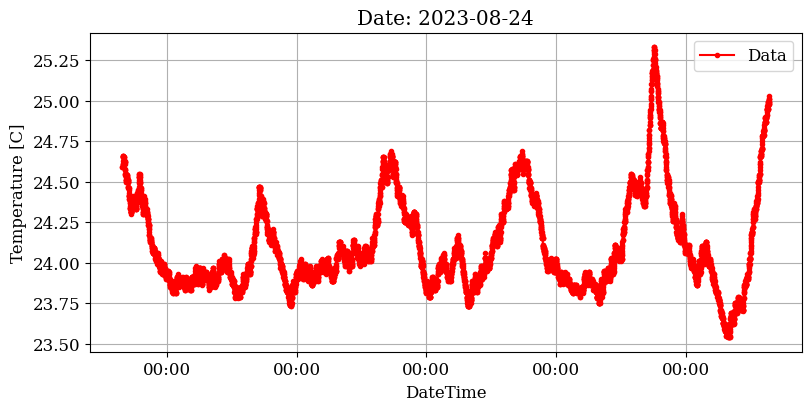

In [22]:
## temperature from omege

if not os.path.isfile(fileNameTemp + '.csv'):
    print('temp file not found...create csv file')    
    read_file = pd.read_excel (fileNameTemp)
    read_file.to_csv (fileNameTemp + '.csv', index = None, header=True)
else: 
    print('temp file found')    

dataFrameTemp = pd.read_csv(fileNameTemp + '.csv', names=['DateTime1', 'DateTime2', 'ambient Temperature [C]','couple Temperature [C]'], skiprows=[0,1,2,3,4,5,6], header=None)
xPlotTemp = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in dataFrameTemp['DateTime1']]
yPlotTemp = dataFrameTemp['ambient Temperature [C]']
## plotting
figHandler, axHandler = plt.subplots(1, 1, layout='constrained')
plt.plot(xPlotTemp, yPlotTemp, '.-r', label='Data')
plt.grid(True); plt.xlabel('DateTime'); plt.ylabel('Temperature [C]'); plt.legend()
axHandler.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
plt.title('Date: ' + str(datetime.datetime.strptime(dataFrameTemp['DateTime1'][0], '%Y-%m-%d %H:%M:%S').date()))
plt.show()

In [ ]:
xPlotPhase[0]

datetime.datetime(2023, 8, 11, 13, 51, 49, 9)

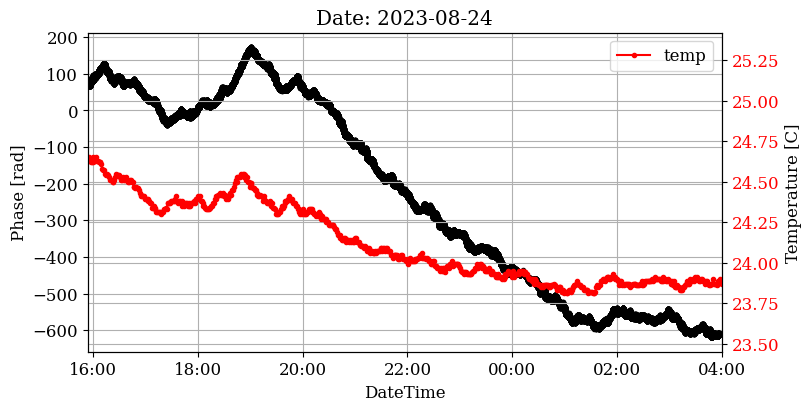

In [32]:
## plotting phase &temp
figHandler, axHandler = plt.subplots(1, 1, layout='constrained')
## plot the phase
axHandler.plot(xPlotPhase, yPlotPhaseAve, '.-k', label='phase')
axHandler.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axHandler.grid(True); axHandler.set_xlabel('DateTime'); axHandler.set_ylabel('Phase [rad]')

## plot the temperature
axHandler = axHandler.twinx() ## copy the axis, but using the same x-axis
axHandler.plot(xPlotTemp, yPlotTemp, '.-r', label='temp')
axHandler.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')); axHandler.tick_params(axis='y', labelcolor='r'); 
axHandler.grid(True); axHandler.set_xlabel('DateTime'); axHandler.set_ylabel('Temperature [C]')

start_date = datetime.datetime(2023, 8, 24, 15, 54, 0)  # Replace with your desired start date
end_date = datetime.datetime(2023, 8, 25, 4, 0, 0)   # Replace with your desired end date
axHandler.set_xlim(start_date, end_date)

plt.legend()
#plt.xlim([xPlotPhase[0],xPlotPhase[54000]])
plt.title('Date: ' + str(datetime.datetime.strptime(dataFrameTemp['DateTime1'][0], '%Y-%m-%d %H:%M:%S').date()))
plt.show()

In [ ]:
## temperature from thermister
biasCurr = 0.1e-3 ## default for 10k

if not os.path.isfile(fileNameTemp + '.csv'):
    print('temp file not found...')
else: 
    dataFrameTemp = pd.read_csv(fileNameTemp + '.csv', names=['DateTime', 'Voltage [V]'], skiprows=[0], header=None)
    dataFrameTemp['Temperature [C]'] = [(1/steinhartHartFun10k(i/biasCurr))-273.15 for i in dataFrameTemp['Voltage [V]']] ## convert to temp from resistance
    
    xPlotTemp = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S.%f') for i in dataFrameTemp['DateTime']]
    yPlotTemp = dataFrameTemp['Temperature [C]']
    
    ## plotting
    figHandler, axHandler = plt.subplots(1, 1, layout='constrained')
    plt.plot(xPlotTemp, yPlotTemp, '.-r', label='Data')
    # function: datetime.datetime.strptime convert string to datetime
    plt.grid(True); plt.xlabel('DateTime'); plt.ylabel('Temperature [C]'); plt.legend()
    axHandler.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
    plt.title('Date: ' + str(datetime.datetime.strptime(dataFrameTemp['DateTime'][0], '%Y-%m-%d %H:%M:%S.%f').date()))
    plt.show()

In [12]:
def getMinMax(arr):
    arr.sort()
    minmax = {"min": arr[0], "max": arr[-1]}
    return minmax

In [13]:
minmax = getMinMax(yPlotTemp) 
print("Minimum element is", minmax["min"])
print("Maximum element is", minmax["max"])
print("peak-peak temperature is", minmax["max"]-minmax["min"])

AttributeError: 'Series' object has no attribute 'sort'